In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats import power as pwr

import matplotlib.pyplot as plt
%matplotlib inline

# Player Retention A/B Testing

## Project Overview:

This project is based on and uses data from the DataCamp project [A/B Testing with Cookie Cat](https://projects.datacamp.com/projects/184). 

### Excerpt from the DataCamp Description of the Game
Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level. It also features singing cats. 

As players progress through the game levels, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition to driving in-app purchases, these gates serve the critical purpose of giving players an enforced break from playing the game, hopefully resulting in the player's enjoyment of the game being increased and prolonged.

### Project Goal

This project aims to find if there is a statistically significant difference in the percentage of player retention by setting the gate at level 30 or 40. I will examine the one-day and seven-day retention rates using two different types of A/B testing techniques. 

### Data Dictionary

The data is from 90,189 players that installed the game while the AB-test was running. The variables are:

- userid - a unique number that identifies each player.
- version - whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
- sum_gamerounds - the number of game rounds played by the player during the first 14 days after install.
- retention_1 - did the player come back and play 1 day after installing?
- retention_7 - did the player come back and play 7 days after installing?

## Data Loading and Cleaning

In [2]:
df = pd.read_csv('cookie_cats.csv')

In [3]:
df.shape

(90189, 5)

In [4]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [6]:
df.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [7]:
df['userid'].nunique() == df.shape[0]

True

In [8]:
df.pivot_table(index='version', aggfunc={'userid':'count'})

,userid
version,
gate_30,44700
gate_40,45489


The data is consistent with what was outlined in the data dictionary. There are no null values, and all features appear to be in the correct data type. In addition, all users are unique, and there are roughly the same amount of users in each game version.

In [9]:
discrepancies = df[(df['retention_1'] == False) & (df['retention_7'] == True)]
discrepancies

,userid,version,sum_gamerounds,retention_1,retention_7
10,1842,gate_40,3,False,True
23,2729,gate_30,105,False,True
90,8788,gate_30,19,False,True
102,10200,gate_40,106,False,True
143,13429,gate_30,60,False,True
...,...,...,...,...,...
89967,9975174,gate_30,26,False,True
90044,9982773,gate_30,1,False,True
90046,9983040,gate_30,137,False,True
90156,9996093,gate_40,23,False,True


In [10]:
discrepancies.pivot_table(index='version', aggfunc={'userid':'count'}) 

,userid
version,
gate_30,1826
gate_40,1773


In [11]:
df.drop(index=discrepancies.index, axis=0, inplace=True)

In [12]:
df.shape

(86590, 5)

There are some discrepancies in the data; logically, it's impossible not to return after the first day and return after the seventh. This discrepancy only accounts for roughly 4% of the data and is roughly the same in both versions. Therefore, I will discard these samples. The resulting data frame consists of 86590 samples.

## Exploratory Data Analysis
### Game Rounds Played

In [13]:
df['sum_gamerounds'].describe()

count    86590.000000
mean        50.369546
std        102.924378
min          0.000000
25%          5.000000
50%         16.000000
75%         49.000000
max       2961.000000
Name: sum_gamerounds, dtype: float64

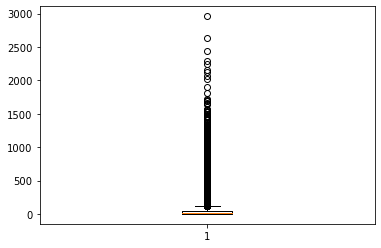

In [14]:
plt.boxplot(df['sum_gamerounds'])
plt.show()

In [15]:
df[df['sum_gamerounds'] > 100].shape[0]

11547

There are around 15% of players that progressed beyond 100 rounds. They skew the data and make it challenging to visualize the distribution for the majority of the players. Therefore, I will remove them from the analysis.

In [16]:
clean_df = df.drop(df[df['sum_gamerounds'] > 100].index, axis=0).copy()

df_g30 = clean_df[clean_df['version'] == 'gate_30']
df_g40 = clean_df[clean_df['version'] == 'gate_40']

In [17]:
def ecdf(column):
    x = sorted(column)
    y = np.arange(1, len(column) + 1) / len(column)
    return x, y

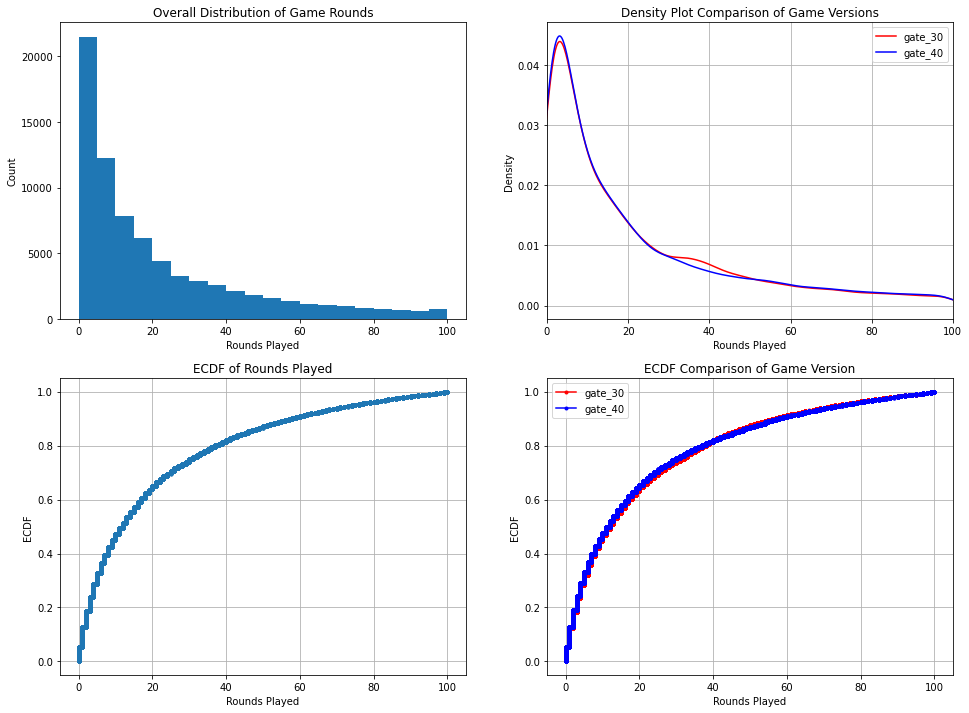

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(16,12))

# Histogram
ax[0,0].hist(clean_df['sum_gamerounds'], bins=20)
ax[0,0].set(title='Overall Distribution of Game Rounds', xlabel='Rounds Played', ylabel='Count')

# Density plots
df_g30['sum_gamerounds'].plot(kind='kde', color='red', label='gate_30', ax=ax[0,1])
df_g40['sum_gamerounds'].plot(kind='kde', color='blue', label='gate_40', ax=ax[0,1])
ax[0,1].grid()
ax[0,1].legend()
ax[0,1].set(title='Density Plot Comparison of Game Versions', xlim=(0,100),
           xlabel='Rounds Played')

# ECDF of total Rounds played
x, y = ecdf(clean_df['sum_gamerounds'])

ax[1,0].plot(x, y, marker='.', linestyle=None)
ax[1,0].grid()
ax[1,0].set(title='ECDF of Rounds Played', xlabel='Rounds Played', ylabel='ECDF')


# ECDF grouped by gates
x30, y30 = ecdf(df_g30['sum_gamerounds'])
x40, y40 = ecdf(df_g40['sum_gamerounds'])

ax[1,1].plot(x30, y30, marker='.', linestyle=None, color='red', label='gate_30')
ax[1,1].plot(x40, y40, marker='.', linestyle=None, color='blue', label='gate_40')
ax[1,1].grid()
ax[1,1].legend()
ax[1,1].set(title='ECDF Comparison of Game Version', xlabel='Rounds Played', ylabel='ECDF')

plt.show()

In [19]:
g30_over30 = round((df_g30[df_g30['sum_gamerounds'] >= 30].shape[0]) / len(df_g30) * 100, 2)
g40_over30 = round((df_g40[df_g40['sum_gamerounds'] >= 30].shape[0]) / len(df_g40) * 100, 2)

print('Percentage of players in gate 30 version past round 30: ', g30_over30, '\n'
     'Percentage of players in gate 40 version past round 30: ', g40_over30, '\n'
     'Difference of  ', round(g30_over30 - g40_over30,2))

Percentage of players in gate 30 version past round 30:  26.36 
Percentage of players in gate 40 version past round 30:  25.46 
Difference of   0.9


In [20]:
g30_over40 = round((df_g30[df_g30['sum_gamerounds'] >= 40].shape[0]) / len(df_g30) * 100, 2)
g40_over40 = round((df_g40[df_g40['sum_gamerounds'] >= 40].shape[0]) / len(df_g40) * 100, 2)

print('Percentage of players in gate 30 version past round 40: ', g30_over40, '\n'
     'Percentage of players in gate 40 version past round 40: ', g40_over40, '\n'
     'Difference of  ', round(g30_over40 - g40_over40, 2))

Percentage of players in gate 30 version past round 40:  18.56 
Percentage of players in gate 40 version past round 40:  18.5 
Difference of   0.06


The visualization shows that around 80% of the players have stopped playing by level 40. When comparing the two gates, the gate 30 version has a higher proportion of players who played past the first few rounds. Then, the two versions have a similar distribution until round 30, where the distribution separates. The Gate 30 version has 0.9% more players that made it past round 30. When comparing the proportion of players that made it past gate 40, the two version are very similar, only a 0.06% difference.

### Retention Rates

In [124]:
print('One day retention rate: ', round(clean_df['retention_1'].mean(),2)*100, '\n'
      'Seven days retention rate: ', round(clean_df['retention_7'].mean(), 2)*100)

One day retention rate:  39.0 
Seven days retention rate:  7.000000000000001


In [21]:
g30_r1 = round(df_g30['retention_1'].mean() * 100, 2)
g40_r1 = round(df_g40['retention_1'].mean() * 100, 2)

print('Percentage of players in gate 30 version that came back after the 1st day: ', g30_r1, '\n'
     'Percentage of players in gate 40 version that came back after the 1st day: ', g40_r1, '\n'
     'Difference of  ', round(g30_r1 - g40_r1,2))

Percentage of players in gate 30 version that came back after the 1st day:  39.09 
Percentage of players in gate 40 version that came back after the 1st day:  38.23 
Difference of   0.86


In [22]:
g30_r7 = round(df_g30['retention_7'].mean() * 100, 2)
g40_r7 = round(df_g40['retention_7'].mean() * 100, 2)

print('Percentage of players in gate 30 version that came back after the 7th day: ', g30_r7, '\n'
     'Percentage of players in gate 40 version that came back after the 7th day: ', g40_r7, '\n'
     'Difference of  ', round(g30_r7 - g40_r7, 2))

Percentage of players in gate 30 version that came back after the 7th day:  7.34 
Percentage of players in gate 40 version that came back after the 7th day:  6.49 
Difference of   0.85


When comparing the overall retention rates between the two groups, the gate30 version is roughly 0.85% higher in both metrics. The gate_30 version seems to perform better in every comparison so far. Next, I will conduct an A/B test to see if these differences are statistically significant.

# A/B Test

I will use two different A/B testing methods to determine if the two different versions are statistically significant. 

### Hypothesis Test

- Define testing parameters
- Determine if the samples meet the normal condition
- Calculate confidence interval
- Calculate P-Value
- Determine if $H_0$ can be rejected

#### Testing Parameters

- Control = Version Gate_30
- Treatment = Version Gate_40

$H_0$: $p_c$ = $p_t$

$H_a$: $p_c$ $\neq$ $p_t$

$alpha$ = 0.05


In [47]:
def cohend(array1, array2):
    # calculate cohen D effect size
    m1 = array1.mean()
    m2 = array2.mean()
    pooled_sd = np.sqrt((array1.std()**2 + array2.std()**2)/2)
    return (m1-m2) / pooled_sd

In [112]:
def ab_test(obs1, obs2, alpha, alternative='two-sided'):
    """
    Calculate normality, P-Value, Effect size and Statistical Power between
    the two group of observations.
    
    Args:
        obs1(numerical, array) = observation of first group
        obs2(numerical, array) = observation of second group
        alpha(numerical) = Threshold of Type 1 Error
        alternative(two-sided, less, greater) = Method of comparison between obs1 and obs2, default is two-sided
        
    Return:
        String with results of normality, p-value, effect size and statistical power.
    """
    
    from scipy import stats
    from statsmodels.stats import power as pwr
    # if samplesize is less than 30 then the normality of distribution have to be checked
    normal = True
    if len(obs1) < 30 or len(obs2) < 30:
        # check both distribution for normality with shapiro test
        norm1 = stats.shapiro(obs1)[1]
        norm2 = stats.shapiro(obs2)[1]
        
        if norm1 < alpha or norm2 < alpha:
            normal = False
            
    # Use T-Test if the distributions are normal else use mann-whitney non-parametric test
    if normal:
        pvalue = stats.ttest_ind(obs1, obs2, alternative=alternative)
    else:
        pvalue = stats.ranksums(obs1, obs2, alternative=alternative)
    
    # calculate statistical power
    analysis = pwr.TTestIndPower()
    effect_size = cohend(obs1, obs2)
    ratio = len(obs1) / len(obs2)
    power = analysis.solve_power(alpha=alpha, effect_size=effect_size, ratio=ratio, nobs1=len(obs1))
    
        
    print('A/B Test Results:')
    print('--------------------')
    print('Averages - Group 1: ', round(obs1.mean(), 2), ' Group 2: ', round(obs2.mean(),2))
    print('--------------------')
    print('Normality of Distribution: ', normal)
    print('--------------------')
    print('P-Value: ', round(pvalue[1], 2))
    print('--------------------')
    print('Effect Size: ', round(effect_size, 2))
    print('--------------------')
    print('Statistical Power: ', round(power,2))

## One-day Retention

In [67]:
ab_test(df_g30['retention_1'], df_g40['retention_1'], alpha=alpha)

A/B Test Results:
--------------------
Retention Rates - Group 1:  0.39  Group 2:  0.38
--------------------
Normality of Distribution:  True
--------------------
P-Value:  0.01
--------------------
Effect Size:  0.02
--------------------
Statistical Power:  0.68


## Seven-day Retention

In [68]:
ab_test(df_g30['retention_7'], df_g40['retention_7'], alpha=alpha)

A/B Test Results:
--------------------
Retention Rates - Group 1:  0.07  Group 2:  0.06
--------------------
Normality of Distribution:  True
--------------------
P-Value:  0.0
--------------------
Effect Size:  0.03
--------------------
Statistical Power:  1.0


The AB test for both retention metrics returned a p-value less than the alpha, thus rejecting the null hypothesis. This result signifies statistically significant differences between the retention rates of the two groups. There is a 2% difference between the groups for the one-day retention metric. In the case of the seven-day retention metric, there is a 3% difference. 

There is a significant difference when comparing the statistical power between the two tests. The test for the one-day metric resulted in a statistical power of 0.68, lower than the industry standard of 0.8. However, the statistical power for the seven-day metric is 1, signifying no chance of making a Type-2 error.

## Game Rounds

In [115]:
ab_test(df_g30['sum_gamerounds'], df_g40['sum_gamerounds'], alpha=alpha)

A/B Test Results:
--------------------
Averages - Group 1:  21.07  Group 2:  20.9
--------------------
Normality of Distribution:  True
--------------------
P-Value:  0.32
--------------------
Effect Size:  0.01
--------------------
Statistical Power:  0.17


When comparing the rounds played for the game, the AB test resulted in a p-value of 0.32, thus unable to reject the null hypothesis. This result shows that there isn't a significant difference between the two versions. 

## Results Summary

Statistics for players with less than 100 rounds played
- Overall retention rate - one-day: 39%, seven-day: 7%.

One day Retention Rates
- Gate30: 39%, Gate40: 38%.
- Statiscally significant different with statistical power of 0.68.

Seven day Retention Rate
- Gate30: 7%, Gate40: 6%.
- Statiscally significant different with statistical power of 1.

Rounds Played
- Percentage of players past round 30 - Gate30: 26.36%, Gate40: 25.46%.
- Percentage of players past round 40 - Gate30: 18.56%, gate40: 18.5%.

## Recommendation

The gate 30 version showed higher retention rate in both one-day and seven-day metrics. The AB test also showed that this difference is statistically significant. Therefore, I recommend implementing the gate 30 version going forward.